In [31]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# from dynamic_routing_analysis import decoding_utils , plot_utils
# import dynamic_routing_analysis as dra
import npc_lims

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#test on spontaneous activity
results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoder_on_spontaneous_20251219_181131/"

session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    pl.col('is_good_behavior').eq(True),
    pl.col('is_engaged').eq(True),
    )['session_id'].to_list()
    )

all_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'bin_center',
    'electrode_group_names',
    'unit_subsample_size',
    'unit_criteria',
    'labels',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [35]:
### make separate query to include repeats - specify session
sel_session='742903_2024-10-22' #the golden session
# sel_session='670180_2023-07-27' #a templeton session
predict_proba_with_repeats_single_session = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        pl.col('session_id').eq(sel_session),
    )#.drop('unit_ids') 
    # .sort('session_id', descending=True)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        # pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'decision_function', 'trial_index',)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index', 'stim_start_time',)
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx', 'bin_center', 'unit_ids', 'labels')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba', 'decision_function', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response', 'trial_index_in_block', 'block_index', 'stim_start_time'),
    )
    .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx', 'bin_center')
    # .group_by('session_id','structure')
    .collect()
)


In [8]:
### spontaneous activity results

predict_proba_with_repeats_single_session_spontaneous = (
    pl.scan_parquet(results_path)
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
        pl.col('session_id').eq(sel_session),
    )#.drop('unit_ids') 
    # .sort('session_id', descending=True)
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='inner',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba_spont').list.len()).alias('trial_index')
        # pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba_spont', 'decision_function_spont', 'pred_label_spont','spont_trial_times','spont_epoch_name','spont_trial_is_rewarded','trial_index',)
    .group_by('session_id', 'structure', 'unit_subsample_size', 'repeat_idx', 'bin_center', 'unit_ids', 'labels')
    .agg(
        pl.col('balanced_accuracy_test', 'total_n_units').first(),
        pl.col('predict_proba_spont', 'decision_function_spont', 'trial_index', 'pred_label_spont','spont_trial_times','spont_epoch_name','spont_trial_is_rewarded'),
    )
    .sort('session_id','structure', 'unit_subsample_size', 'repeat_idx', 'bin_center')
    # .group_by('session_id','structure')
    .collect()
)

In [36]:
predict_proba_with_repeats_single_session_spontaneous

session_id,structure,unit_subsample_size,repeat_idx,bin_center,unit_ids,labels,balanced_accuracy_test,total_n_units,predict_proba_spont,decision_function_spont,trial_index,pred_label_spont,spont_trial_times,spont_epoch_name,spont_trial_is_rewarded
str,str,u16,u16,f64,list[str],list[i64],f64,u32,list[f64],list[f64],list[i64],list[str],list[f64],list[str],list[bool]
"""742903_2024-10-22""","""ACAd""",20,0,-0.25,"[""742903_2024-10-22_A-104"", ""742903_2024-10-22_A-106"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.598777,134,"[0.545796, 0.437744, … 0.786226]","[0.183699, -0.250324, … 1.302322]","[0, 1, … 361]","[""vis"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",20,1,-0.25,"[""742903_2024-10-22_A-100"", ""742903_2024-10-22_A-103"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.749092,134,"[0.145757, 0.386051, … 0.747154]","[-1.768276, -0.463944, … 1.083492]","[0, 1, … 361]","[""aud"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",20,2,-0.25,"[""742903_2024-10-22_A-109"", ""742903_2024-10-22_A-111"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.728337,134,"[0.155201, 0.352671, … 0.681748]","[-1.694381, -0.607321, … 0.761818]","[0, 1, … 361]","[""aud"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",20,3,-0.25,"[""742903_2024-10-22_A-103"", ""742903_2024-10-22_A-104"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.726555,134,"[0.435014, 0.482542, … 0.71927]","[-0.261424, -0.069859, … 0.940845]","[0, 1, … 361]","[""aud"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""ACAd""",20,4,-0.25,"[""742903_2024-10-22_A-100"", ""742903_2024-10-22_A-103"", … ""742903_2024-10-22_A-99""]","[0, 0, … 1]",0.717435,134,"[0.204531, 0.402423, … 0.749185]","[-1.358215, -0.395378, … 1.094273]","[0, 1, … 361]","[""aud"", ""aud"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""742903_2024-10-22""","""TTd""",20,20,-0.25,"[""742903_2024-10-22_E-10"", ""742903_2024-10-22_E-12"", … ""742903_2024-10-22_F-0""]","[0, 0, … 1]",0.55587,240,"[0.504319, 0.294013, … 0.382435]","[0.017277, -0.875972, … -0.479224]","[0, 1, … 361]","[""vis"", ""aud"", … ""aud""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""TTd""",20,21,-0.25,"[""742903_2024-10-22_E-1006"", ""742903_2024-10-22_E-1007"", … ""742903_2024-10-22_E-980""]","[0, 0, … 1]",0.577952,240,"[0.500904, 0.572458, … 0.838788]","[0.003617, 0.291885, … 1.649237]","[0, 1, … 361]","[""vis"", ""vis"", … ""vis""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"
"""742903_2024-10-22""","""TTd""",20,22,-0.25,"[""742903_2024-10-22_E-1004"", ""742903_2024-10-22_E-1006"", … ""742903_2024-10-22_F-0""]","[0, 0, … 1]",0.501572,240,"[0.498452, 0.437822, … 0.463096]","[-0.006193, -0.250008, … -0.147884]","[0, 1, … 361]","[""aud"", ""aud"", … ""aud""]","[1295.04894, 1300.615607, … 7382.18208]","[""Spontaneous"", ""Spontaneous"", … ""Spontaneous""]","[false, false, … false]"


In [37]:
predict_proba_single_session_pd=predict_proba_with_repeats_single_session.to_pandas()
predict_proba_with_repeats_single_session_spontaneous_pd=predict_proba_with_repeats_single_session_spontaneous.to_pandas()

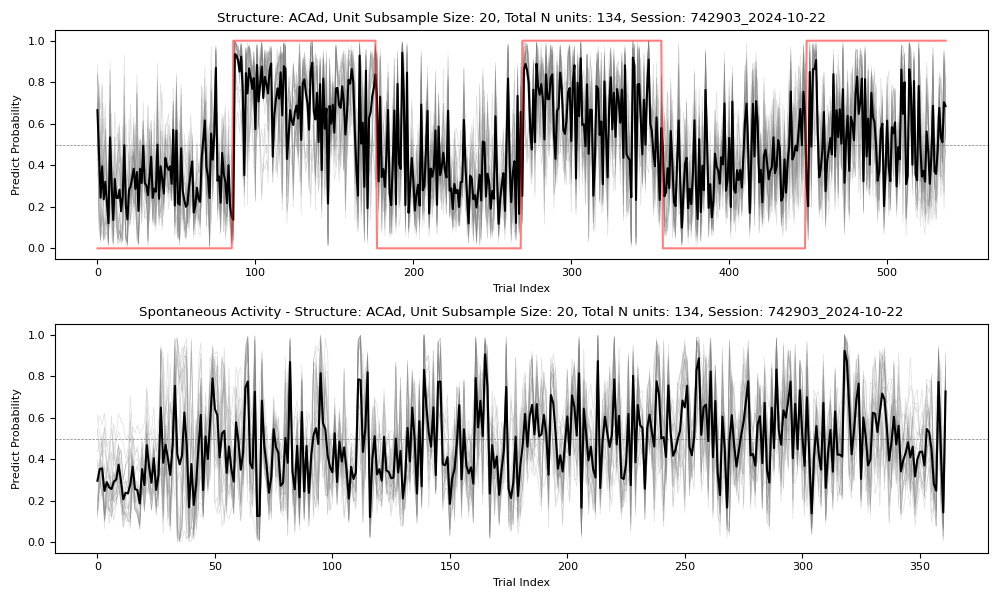

In [ ]:
# show individual repeats, averages over repeats, etc.
sel_bin_center=-0.25
sel_structure='ACAd'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')

trial_index=structure_predict_proba['trial_index'].iloc[0]
total_n_units=structure_predict_proba['total_n_units'].iloc[0]

trial_index_spont=structure_predict_proba_spont['trial_index'].iloc[0]

spont_is_rewarded=structure_predict_proba_spont['spont_trial_is_rewarded'].iloc[0]

epoch_names=structure_predict_proba_spont['spont_epoch_name'].iloc[0]

fig,ax=plt.subplots(2,1,figsize=(10,6),sharey=True)
ax[0].axhline(0.5, color='grey', linestyle='--', linewidth=0.5)
ax[0].plot(trial_index, np.vstack(structure_predict_proba['predict_proba'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax[0].plot(trial_index, np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0), color='black')
ax[0].plot(trial_index, structure_predict_proba['labels'].values[0], color='red', alpha=0.5, label='true label')
ax[0].set_xlabel('Trial Index')
ax[0].set_ylabel('Predict Probability')
ax[0].set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Total N units: {total_n_units}, Session: {sel_session}')

ax[1].axhline(0.5, color='grey', linestyle='--', linewidth=0.5)
ax[1].plot(trial_index_spont, np.vstack(structure_predict_proba_spont['predict_proba_spont'].values).T, color='grey', alpha=0.25, linewidth=0.5)
ax[1].plot(trial_index_spont, np.mean(np.vstack(structure_predict_proba_spont['predict_proba_spont'].values),0), color='black')
# ax[1].plot(np.where(spont_is_rewarded)[0], structure_predict_proba_spont['predict_proba_spont'].values[0][spont_is_rewarded],
#            marker='o',color='blue', linestyle='')
# ax[1].plot(trial_index_spont, structure_predict_proba_spont['labels'].values[0], color='red', alpha=0.5, label='true label')
ax[1].set_xlabel('Trial Index')
ax[1].set_ylabel('Predict Probability')
ax[1].set_title(f'Spontaneous Activity - Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Total N units: {total_n_units}, Session: {sel_session}')

fig.tight_layout()


In [ ]:
#get epochs
session_id=sel_session
epochs=pd.read_parquet(
    npc_lims.get_cache_path('epochs',session_id,version='any')
)
epochs

,start_time,stop_time,script_name,notes,interval_names,tags,session_idx,date,subject_id,session_id
id,,,,,,,,,,
0,44.79145,915.504433,RFMapping,,"[vis_rf_mapping_trials, aud_rf_mapping_trials]",[mapping],0,2024-10-22,742903,742903_2024-10-22
1,925.76399,1276.573301,OptoTagging,,[optotagging_trials],[optotagging],0,2024-10-22,742903,742903_2024-10-22
2,1286.79894,1889.936699,Spontaneous,,[spontaneous_trials],[spontaneous],0,2024-10-22,742903,742903_2024-10-22
3,1900.72890,2503.800740,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2024-10-22,742903,742903_2024-10-22
4,2514.35961,6155.325601,DynamicRouting1,,"[trials, performance]","[task, rewards]",0,2024-10-22,742903,742903_2024-10-22
5,6166.13478,6769.256588,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2024-10-22,742903,742903_2024-10-22
6,6779.73208,7382.853794,Spontaneous,,[spontaneous_trials],[spontaneous],0,2024-10-22,742903,742903_2024-10-22
7,7393.26257,7741.754331,OptoTagging,,[optotagging_trials],[optotagging],0,2024-10-22,742903,742903_2024-10-22


In [53]:
predict_proba_single_session_pd['structure'].unique()

array(['ACAd', 'ACAv', 'CP', 'GU', 'ILA', 'LSr', 'MOs', 'ORBl', 'ORBm',
       'ORBvl', 'PL', 'SSp', 'SSs', 'TTd'], dtype=object)

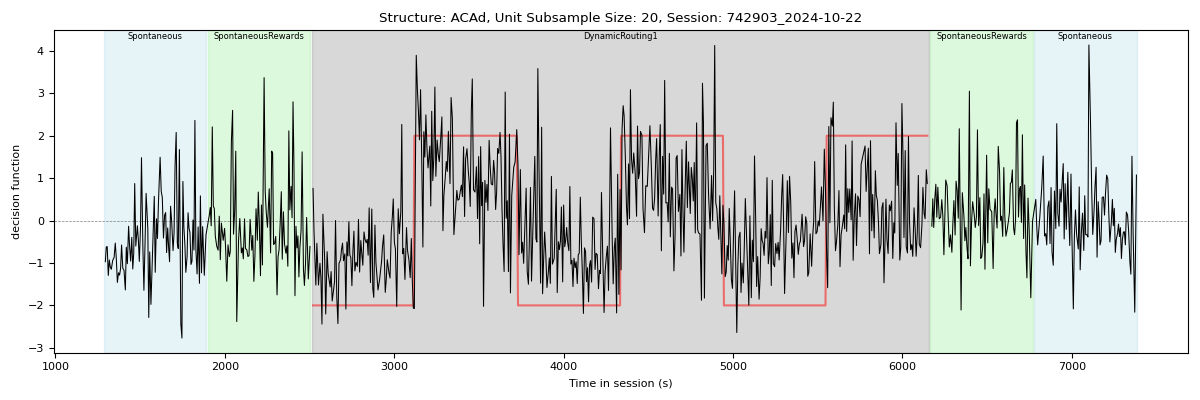

In [83]:
#plot predict proba across epochs, shade epochs
sel_structure='ACAd'
plot_data_string='decision_function' # 'decision_function' or 'predict_proba'
sel_unit_subsample=20
if sel_unit_subsample is None or sel_unit_subsample == 'all':
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size.isna() and bin_center==@sel_bin_center')
else:
    structure_predict_proba=predict_proba_single_session_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')
    structure_predict_proba_spont=predict_proba_with_repeats_single_session_spontaneous_pd.query('structure==@sel_structure and unit_subsample_size==@sel_unit_subsample and bin_center==@sel_bin_center')

trial_times=structure_predict_proba['stim_start_time'].iloc[0]
total_n_units=structure_predict_proba['total_n_units'].iloc[0]

trial_times_spont=structure_predict_proba_spont['spont_trial_times'].iloc[0]

pretask_spont_index=trial_times_spont<trial_times[0]

fig,ax=plt.subplots(figsize=(12,4))
if plot_data_string=='predict_proba':
    ax.axhline(0.5, color='grey', linestyle='--', linewidth=0.5)
    ax.plot(trial_times, structure_predict_proba['labels'].values[0], color='red', alpha=0.5, label='true label')
    ax.set_ylabel('p(vis context)')
elif plot_data_string=='decision_function':
    ax.axhline(0.0, color='grey', linestyle='--', linewidth=0.5)
    ax.plot(trial_times, structure_predict_proba['labels'].values[0]*4-2, color='red', alpha=0.5, label='true label')
    ax.set_ylabel('decision function')

ax.plot(trial_times, np.mean(np.vstack(structure_predict_proba[plot_data_string].values),0), color='black', label='task trials', linewidth=0.75)
ax.plot(trial_times_spont[pretask_spont_index], 
        np.mean(np.vstack(structure_predict_proba_spont[f'{plot_data_string}_spont'].values),0)[pretask_spont_index], 
        color='black', label='pre-task spontaneous', linewidth=0.75)
ax.plot(trial_times_spont[~pretask_spont_index], 
np.mean(np.vstack(structure_predict_proba_spont[f'{plot_data_string}_spont'].values),0)[~pretask_spont_index], 
        color='black', label='post-task spontaneous', linewidth=0.75)

ax.set_xlabel('Time in session (s)')

ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}')
# ax.legend()

#add patches for Spontaneous, SpontaneousRewards, DynamicRouting1 epochs
for _,epoch_row in epochs.iterrows():
    epoch_start=epoch_row['start_time']
    epoch_end=epoch_row['stop_time']
    epoch_name=epoch_row['script_name']
    if epoch_name=='Spontaneous':
        color='lightblue'
    elif epoch_name=='SpontaneousRewards':
        color='lightgreen'
    elif epoch_name=='DynamicRouting1':
        color='grey'
    else:
        continue
    ax.axvspan(epoch_start, epoch_end, color=color, alpha=0.3, label=epoch_name)
    ymin, ymax = ax.get_ylim()
    ax.text((epoch_start+epoch_end)/2, ymax*0.99, epoch_name, ha='center', va='top', fontsize=6,)

    

fig.tight_layout()

In [79]:
r,p=stats.pearsonr(np.mean(np.vstack(structure_predict_proba['decision_function'].values),0),np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0))
r

0.9905734157391172

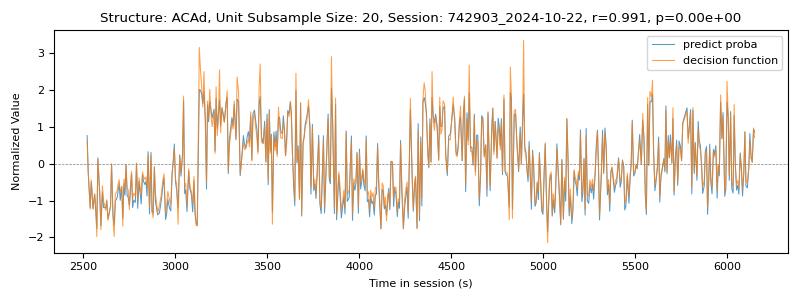

In [90]:
fig,ax=plt.subplots(figsize=(8,3))
norm_predict_proba=np.mean(np.vstack(structure_predict_proba['predict_proba'].values),0)-0.5
# norm_predict_proba=(norm_predict_proba-min(norm_predict_proba))
# norm_predict_proba=norm_predict_proba/(max(np.abs(norm_predict_proba)))
norm_predict_proba=norm_predict_proba/np.std(norm_predict_proba)

norm_decision_function=np.mean(np.vstack(structure_predict_proba['decision_function'].values),0)
# norm_decision_function=(norm_decision_function-min(norm_decision_function))
# norm_decision_function=norm_decision_function/(max(np.abs(norm_decision_function)))
norm_decision_function=norm_decision_function/np.std(norm_decision_function)

ax.axhline(0.0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(trial_times, norm_predict_proba, color='tab:blue', label='predict proba',linewidth=0.75,alpha=0.75)
ax.plot(trial_times, norm_decision_function, color='tab:orange', label='decision function',linewidth=0.75,alpha=0.75)
ax.set_xlabel('Time in session (s)')
ax.set_ylabel('Normalized Value')
ax.set_title(f'Structure: {sel_structure}, Unit Subsample Size: {sel_unit_subsample}, Session: {sel_session}, r={r:.3f}, p={p:.2e}')
ax.legend()

fig.tight_layout()

In [ ]:
#correlate each epoch's predict proba across areas
sel_structure_1='ACAd'
sel_structure_2='ORBl'

